# Extract Landmarks Data in Melbourne from Wikipedia Interactively

<a id=toc>

Extract landmarks data:
- category, 
- name, 
- (latitude, longitude)

from Wikipedia page [landmarks in Melbourne](https://en.wikipedia.org/wiki/Template:Melbourne_landmarks) in an interactive way.

In [1]:
%matplotlib inline

import requests, re, os
from bs4 import BeautifulSoup
from bs4.element import Tag
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lxml
from fastkml import kml, styles
from shapely.geometry import Point

URL for the landmarks in the Melbourne city centre.

In [2]:
#url = 'https://en.wikipedia.org/wiki/Template:Melbourne_landmarks'
url = 'https://en.wikipedia.org/wiki/Template:Melbourne_landmarks?action=render' # cleaner HTML
data_dir = '../data'
fpoi = os.path.join(data_dir, 'poi-Melb-0.csv')

In [3]:
response = requests.get(url, timeout=10)

In [4]:
html = response.text
soup = BeautifulSoup(html, 'html.parser')

In [5]:
#print(soup.prettify())

### Extract POI coordinates from its Wikipedia page

**NOTE** that there could be more than one coordinate pairs exists in a page, e.g. [Yarra River](https://en.wikipedia.org/wiki/Yarra_River).

In [6]:
def extract_coord(url):
    """
    Assume a URL of a location with a Wikipedia page
    """
    url1 = url + '?action=render' # cleaner HTML
    response = requests.get(url1, timeout=10)
    html = response.text
    soup = BeautifulSoup(html, 'html.parser')
    coords = list(soup.find_all('span', {'class':'geo-dec'}))
    if coords is None or len(coords) == 0:
        print('No Geo-coordinates found')
        return
    
    idx = 0
    if len(coords) > 1:
        if len(coords) == 2 and coords[0].string == coords[1].string:
            idx = 0
        else:
            print('WARN: more than one geo-coordinates detected!')
            print('please check the actual page', url)
            for i, c in enumerate(coords): 
                  print('%d: %s' % (i, c.string))
            ii = input('Input the index of the correct coordinates... ')
            idx = int(ii)
            assert(0 <= idx < len(coords))
    
    coord = coords[idx]
    children = list(coord.children)
    assert(len(children) > 0)
    coordstr = children[0]
    #print(coordstr)
    
    ss = re.sub(r'\s+', ',', coordstr).split(',') # replace blank spaces with ','
    assert(len(ss) == 2)
    latstr = ss[0].split('°') # e.g. 37.82167°S
    lonstr = ss[1].split('°') # e.g. 144.96778°E
    
    assert(len(latstr) == 2 and len(lonstr) == 2)
    lat = float(latstr[0]) if latstr[1] == 'N' else -1 * float(latstr[0])
    lon = float(lonstr[0]) if lonstr[1] == 'E' else -1 * float(lonstr[0])
    
    print(lat, lon)
    return (lat, lon, url)

In [7]:
extract_coord('https://en.wikipedia.org/wiki/Yarra_River')

WARN: more than one geo-coordinates detected!
please check the actual page https://en.wikipedia.org/wiki/Yarra_River
0: 37.74917°S 146.14056°E
1: 37.85194°S 144.90833°E
2: 37.85194°S 144.90833°E
Input the index of the correct coordinates... 1
-37.85194 144.90833


(-37.85194, 144.90833, 'https://en.wikipedia.org/wiki/Yarra_River')

Extract POI data, e.g. category, name, coordinates, from a HTML string retrieved from Wikipedia.

In [8]:
def extract_poi(html):
    """
    Assume POI category is a string in <th>
    POI name and hyperlink is in <li> contained in an unordered list <ul> 
    """
    soup = BeautifulSoup(html, 'html.parser')
    th = soup.find('th')
    if th is None:
        print('NO POI category found')
        return
    assert(len(th.contents) > 0)
    cat = th.contents[0]
    print('CAT:', cat)
    
    ul = soup.find('ul')
    if ul is None:
        print('NO POI found')
        return
    
    poi_data = [] # (name, cat, lat, lon, url)
    
    for li in ul.children:
        #print(type(li), li)
        if isinstance(li, Tag):
            addr = ''.join(['https:', li.a['href']])
            children = list(li.a.children)
            assert(len(children) > 0)            
            name = children[0]
            print(addr, name)
            ret = extract_coord(addr)
            if ret is not None:
                poi_data.append((name, cat, ret[0], ret[1], ret[2]))
    return poi_data

Extract POI data from landmarks in Melbourne recorded in [this Wikipedia page](https://en.wikipedia.org/wiki/Template:Melbourne_landmarks).

In [9]:
#columns = ['Name', 'Category', 'Latitude', 'Longitude']
columns = ['poiName', 'poiTheme', 'poiLat', 'poiLon', 'poiURL']
poi_df = pd.DataFrame(columns=columns)

In [10]:
table = soup.find('table', {'class':'navbox-inner'}) # this class info was found by looking at the raw HTML text

Interactively check if the portion of HTML contains a category and a list of POIs of that category.

In [11]:
cnt = 0
hline = '-'*90
for c in table.children:
    print(hline)
    print('NODE %d BEGIN' % cnt)
    print(c)
    print('NODE %d END' % cnt)
    print(hline)
    k = input('Press [Y] or [y] to extract POI, press any other key to ignore ')
    if k == 'Y' or k == 'y':
        print('Extracting POI...')
        poi_data = extract_poi(str(c))
        for t in poi_data: poi_df.loc[poi_df.shape[0]] = [t[i] for i in range(len(t))]
    else:
        print('IGNORED.')
    print('\n\n')
    
    cnt += 1

------------------------------------------------------------------------------------------
NODE 0 BEGIN


NODE 0 END
------------------------------------------------------------------------------------------
Press [Y] or [y] to extract POI, press any other key to ignore 
IGNORED.



------------------------------------------------------------------------------------------
NODE 1 BEGIN
<tr>
<th class="navbox-title" colspan="2" scope="col">
<div class="plainlinks hlist navbar mini">
<ul>
<li class="nv-view"><strong class="selflink"><abbr style=";;background:none transparent;border:none;" title="View this template">v</abbr></strong></li>
<li class="nv-talk"><a href="//en.wikipedia.org/wiki/Template_talk:Melbourne_landmarks" title="Template talk:Melbourne landmarks"><abbr style=";;background:none transparent;border:none;" title="Discuss this template">t</abbr></a></li>
<li class="nv-edit"><a class="external text" href="//en.wikipedia.org/w/index.php?title=Template:Melbourne_landmarks&amp;a

Latitude/Longitude statistics.

In [12]:
poi_df.head()

,poiName,poiTheme,poiLat,poiLon,poiURL
0,Arts Precinct,City precincts,-37.82167,144.96778,https://en.wikipedia.org/wiki/Melbourne_Arts_P...
1,Docklands,City precincts,-37.81700,144.94600,"https://en.wikipedia.org/wiki/Docklands,_Victoria"
2,Government Precinct,City precincts,-37.81190,144.97300,"https://en.wikipedia.org/wiki/Spring_Street,_M..."
3,Little Italy,City precincts,-37.79972,144.96694,"https://en.wikipedia.org/wiki/Little_Italy,_Me..."
4,Paris End,City precincts,-37.81680,144.96220,"https://en.wikipedia.org/wiki/Collins_Street,_..."


In [13]:
print('#POIs:', poi_df.shape[0])

#POIs: 93


In [14]:
print('Latitude Range:', poi_df['poiLat'].max() - poi_df['poiLat'].min())
poi_df['poiLat'].describe()

Latitude Range: 10.0380056


count    93.000000
mean    -37.711683
std       1.025451
min     -37.970000
25%     -37.822324
50%     -37.816853
75%     -37.810560
max     -27.931994
Name: poiLat, dtype: float64

In [15]:
print('Longitude Range:', poi_df['poiLon'].max() - poi_df['poiLon'].min())
poi_df['poiLon'].describe()

Longitude Range: 8.5453922


count     93.000000
mean     145.055063
std        0.873807
min      144.843330
25%      144.961670
50%      144.966777
75%      144.973290
max      153.388722
Name: poiLon, dtype: float64

Scatter plot.

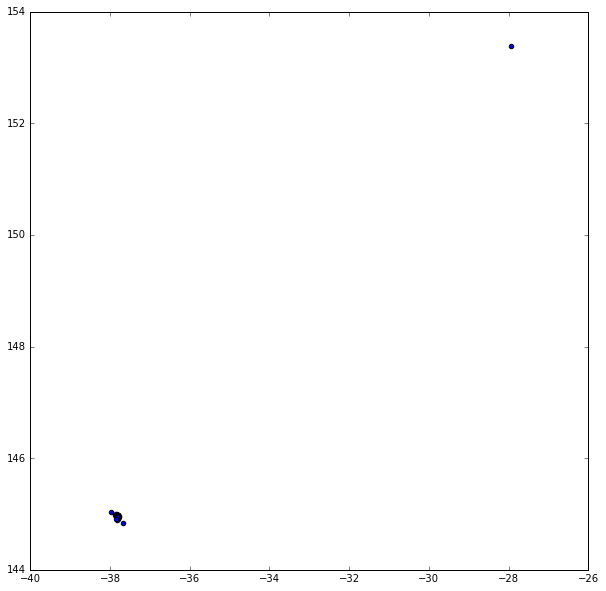

In [16]:
plt.figure(figsize=[10, 10])
plt.scatter(poi_df['poiLat'], poi_df['poiLon'])

The outlier is the [Harbour Town Docklands](https://en.wikipedia.org/wiki/Harbour_Town) in category Shopping, with a coordinates actually in Queensland, the Harbour Town shopping centre in Docklands Victoria was sold in 2014, which could likely result changes of its wiki page.

### Filtering out the outliers

In [17]:
lat_range = [-39, -36]
lon_range = [143, 147]

In [18]:
poi_df = poi_df[poi_df['poiLat'] > min(lat_range)]
poi_df = poi_df[poi_df['poiLat'] < max(lat_range)]
poi_df = poi_df[poi_df['poiLon'] > min(lon_range)]
poi_df = poi_df[poi_df['poiLon'] < max(lon_range)]

Latitude/Longitude statistics.

In [19]:
print('#POIs:', poi_df.shape[0])

#POIs: 92


In [20]:
print('Latitude Range:', poi_df['poiLat'].max() - poi_df['poiLat'].min())
poi_df['poiLat'].describe()

Latitude Range: 0.29667


count    92.000000
mean    -37.817983
std       0.025838
min     -37.970000
25%     -37.822392
50%     -37.816896
75%     -37.810931
max     -37.673330
Name: poiLat, dtype: float64

In [21]:
print('Longitude Range:', poi_df['poiLon'].max() - poi_df['poiLon'].min())
poi_df['poiLon'].describe()

Longitude Range: 0.18667


count     92.000000
mean     144.964479
std        0.021182
min      144.843330
25%      144.961602
50%      144.966443
75%      144.973266
max      145.030000
Name: poiLon, dtype: float64

Scatter plot.

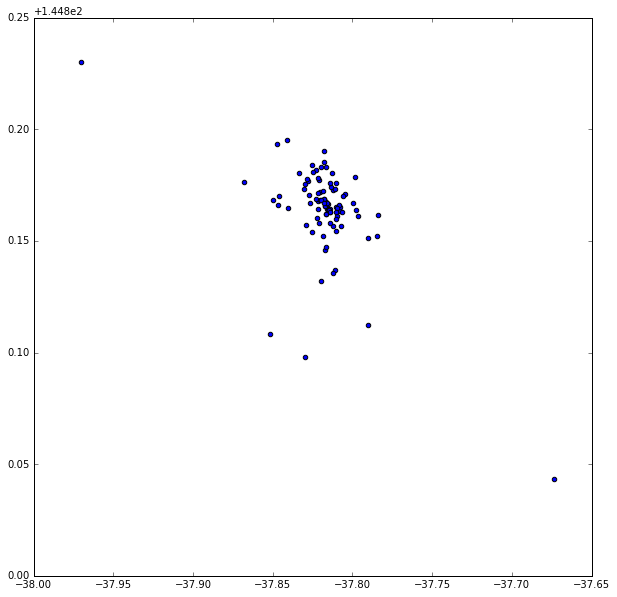

In [22]:
plt.figure(figsize=[10, 10])
plt.scatter(poi_df['poiLat'], poi_df['poiLon'])

### Filtering POIs with the same wikipage and coordinates but associated with several names and categories

In [23]:
print('#POIs:', poi_df.shape[0])
print('#URLs:', poi_df['poiURL'].unique().shape[0])

#POIs: 92
#URLs: 90


In [24]:
duplicated = poi_df['poiURL'].duplicated()
duplicated[duplicated == True]

15    True
37    True
Name: poiURL, dtype: bool

In [25]:
print(poi_df.loc[15, 'poiURL'])
poi_df[poi_df['poiURL'] == poi_df.loc[15, 'poiURL']]

https://en.wikipedia.org/wiki/Collins_Street,_Melbourne


,poiName,poiTheme,poiLat,poiLon,poiURL
4,Paris End,City precincts,-37.8168,144.9622,"https://en.wikipedia.org/wiki/Collins_Street,_..."
15,Collins Street,Shopping,-37.8168,144.9622,"https://en.wikipedia.org/wiki/Collins_Street,_..."


This is a place located at Melbourne CBD, let's choose the second item with category 'Shopping'.

In [26]:
poi_df.drop(4, axis=0, inplace=True)

In [27]:
poi_df.head()

,poiName,poiTheme,poiLat,poiLon,poiURL
0,Arts Precinct,City precincts,-37.82167,144.96778,https://en.wikipedia.org/wiki/Melbourne_Arts_P...
1,Docklands,City precincts,-37.81700,144.94600,"https://en.wikipedia.org/wiki/Docklands,_Victoria"
2,Government Precinct,City precincts,-37.81190,144.97300,"https://en.wikipedia.org/wiki/Spring_Street,_M..."
3,Little Italy,City precincts,-37.79972,144.96694,"https://en.wikipedia.org/wiki/Little_Italy,_Me..."
5,RMIT City,City precincts,-37.80778,144.96333,https://en.wikipedia.org/wiki/City_campus_of_t...


In [28]:
print(poi_df.loc[37, 'poiURL'])
poi_df[poi_df['poiURL'] == poi_df.loc[37, 'poiURL']]

https://en.wikipedia.org/wiki/Melbourne_General_Post_Office


,poiName,poiTheme,poiLat,poiLon,poiURL
19,GPO Melbourne,Shopping,-37.81384,144.963028,https://en.wikipedia.org/wiki/Melbourne_Genera...
37,General Post Office,Institutions,-37.81384,144.963028,https://en.wikipedia.org/wiki/Melbourne_Genera...


For a Post Office, Let's choose the second item with category 'Institutions'.

In [29]:
poi_df.drop(19, axis=0, inplace=True)

In [30]:
poi_df.head(20)

,poiName,poiTheme,poiLat,poiLon,poiURL
0,Arts Precinct,City precincts,-37.821670,144.967780,https://en.wikipedia.org/wiki/Melbourne_Arts_P...
1,Docklands,City precincts,-37.817000,144.946000,"https://en.wikipedia.org/wiki/Docklands,_Victoria"
2,Government Precinct,City precincts,-37.811900,144.973000,"https://en.wikipedia.org/wiki/Spring_Street,_M..."
3,Little Italy,City precincts,-37.799720,144.966940,"https://en.wikipedia.org/wiki/Little_Italy,_Me..."
5,RMIT City,City precincts,-37.807780,144.963330,https://en.wikipedia.org/wiki/City_campus_of_t...
6,Southbank,City precincts,-37.829000,144.957000,"https://en.wikipedia.org/wiki/Southbank,_Victoria"
7,Sports and Entertainment Precinct,City precincts,-37.816670,144.983330,https://en.wikipedia.org/wiki/Melbourne_Sports...
8,University of Melbourne,City precincts,-37.796300,144.961400,https://en.wikipedia.org/wiki/University_of_Me...
9,Block Arcade,Shopping,-37.815830,144.964440,"https://en.wikipedia.org/wiki/Block_Arcade,_Me..."
10,Bourke Street,Shopping,-37.813900,144.964520,"https://en.wikipedia.org/wiki/Bourke_Street,_M..."


### Check distance between POIs

In [31]:
def calc_dist_vec(longitudes1, latitudes1, longitudes2, latitudes2):
    """Calculate the distance (unit: km) between two places on earth, vectorised"""
    # convert degrees to radians
    lng1 = np.radians(longitudes1)
    lat1 = np.radians(latitudes1)
    lng2 = np.radians(longitudes2)
    lat2 = np.radians(latitudes2)
    radius = 6371.0088 # mean earth radius, en.wikipedia.org/wiki/Earth_radius#Mean_radius

    # The haversine formula, en.wikipedia.org/wiki/Great-circle_distance
    dlng = np.fabs(lng1 - lng2)
    dlat = np.fabs(lat1 - lat2)
    dist =  2 * radius * np.arcsin( np.sqrt( 
                (np.sin(0.5*dlat))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(0.5*dlng))**2 ))
    return dist

In [32]:
poi_dist_df = pd.DataFrame(data=np.zeros((poi_df.shape[0], poi_df.shape[0]), dtype=np.float), \
                           index=poi_df.index, columns=poi_df.index)
for ix in poi_df.index:
    dists = calc_dist_vec(poi_df.loc[ix, 'poiLon'], poi_df.loc[ix, 'poiLat'], poi_df['poiLon'], poi_df['poiLat'])
    poi_dist_df.loc[ix] = dists

POI pairs that are less than 50 metres.

In [33]:
check_ix = []
for i in range(poi_df.index.shape[0]):
    for j in range(i+1, poi_df.index.shape[0]):
        if poi_dist_df.iloc[i, j] < 0.05:  # less 50m
            check_ix = check_ix + [poi_df.index[i], poi_df.index[j]]
            print(poi_df.index[i], poi_df.index[j])

14 18
25 46
33 35
33 76
35 76


In [34]:
poi_df.loc[check_ix]

,poiName,poiTheme,poiLat,poiLon,poiURL
14,Centre Place,Shopping,-37.816583,144.965500,"https://en.wikipedia.org/wiki/Centre_Place,_Me..."
18,Flinders Lane,Shopping,-37.816940,144.965560,"https://en.wikipedia.org/wiki/Flinders_Lane,_M..."
25,Queen Victoria Village,Shopping,-37.810000,144.965200,https://en.wikipedia.org/wiki/Queen_Victoria_V...
46,State Library of Victoria,Institutions,-37.809801,144.964787,https://en.wikipedia.org/wiki/State_Library_of...
33,Australian Centre for the Moving Image,Public galleries,-37.817624,144.968591,https://en.wikipedia.org/wiki/Australian_Centr...
35,NGV Australia,Public galleries,-37.817798,144.968714,https://en.wikipedia.org/wiki/Ian_Potter_Centr...
33,Australian Centre for the Moving Image,Public galleries,-37.817624,144.968591,https://en.wikipedia.org/wiki/Australian_Centr...
76,Federation Square,Parks and spaces,-37.817798,144.968714,https://en.wikipedia.org/wiki/Federation_Square
35,NGV Australia,Public galleries,-37.817798,144.968714,https://en.wikipedia.org/wiki/Ian_Potter_Centr...
76,Federation Square,Parks and spaces,-37.817798,144.968714,https://en.wikipedia.org/wiki/Federation_Square


In [35]:
print(poi_df.loc[33, 'poiURL'])
print(poi_df.loc[35, 'poiURL'])
print(poi_df.loc[76, 'poiURL'])

https://en.wikipedia.org/wiki/Australian_Centre_for_the_Moving_Image
https://en.wikipedia.org/wiki/Ian_Potter_Centre:_NGV_Australia
https://en.wikipedia.org/wiki/Federation_Square


According to the above wikipage,
- *"The Australian Centre for the Moving Image (ACMI) is a ... It is located in Federation Square, in Melbourne"*.
- *"The Ian Potter Centre: NGV Australia houses the Australian part of the art collection of the National Gallery of Victoria (NGV). It is located at Federation Square in Melbourne ..."*

So let's just keep the Federation Square.

In [36]:
poi_df.drop(33, axis=0, inplace=True)
poi_df.drop(35, axis=0, inplace=True)

In [37]:
poi_df.head(35)

,poiName,poiTheme,poiLat,poiLon,poiURL
0,Arts Precinct,City precincts,-37.821670,144.967780,https://en.wikipedia.org/wiki/Melbourne_Arts_P...
1,Docklands,City precincts,-37.817000,144.946000,"https://en.wikipedia.org/wiki/Docklands,_Victoria"
2,Government Precinct,City precincts,-37.811900,144.973000,"https://en.wikipedia.org/wiki/Spring_Street,_M..."
3,Little Italy,City precincts,-37.799720,144.966940,"https://en.wikipedia.org/wiki/Little_Italy,_Me..."
5,RMIT City,City precincts,-37.807780,144.963330,https://en.wikipedia.org/wiki/City_campus_of_t...
6,Southbank,City precincts,-37.829000,144.957000,"https://en.wikipedia.org/wiki/Southbank,_Victoria"
7,Sports and Entertainment Precinct,City precincts,-37.816670,144.983330,https://en.wikipedia.org/wiki/Melbourne_Sports...
8,University of Melbourne,City precincts,-37.796300,144.961400,https://en.wikipedia.org/wiki/University_of_Me...
9,Block Arcade,Shopping,-37.815830,144.964440,"https://en.wikipedia.org/wiki/Block_Arcade,_Me..."
10,Bourke Street,Shopping,-37.813900,144.964520,"https://en.wikipedia.org/wiki/Bourke_Street,_M..."


### Save POI data to file

In [38]:
#poi_ = poi_df[['poiTheme', 'poiLon', 'poiLat']].copy()
poi_ = poi_df.copy()
poi_.reset_index(inplace=True)
poi_.drop('index', axis=1, inplace=True)
poi_.index.name = 'poiID'
poi_

,poiName,poiTheme,poiLat,poiLon,poiURL
poiID,,,,,
0,Arts Precinct,City precincts,-37.821670,144.967780,https://en.wikipedia.org/wiki/Melbourne_Arts_P...
1,Docklands,City precincts,-37.817000,144.946000,"https://en.wikipedia.org/wiki/Docklands,_Victoria"
2,Government Precinct,City precincts,-37.811900,144.973000,"https://en.wikipedia.org/wiki/Spring_Street,_M..."
3,Little Italy,City precincts,-37.799720,144.966940,"https://en.wikipedia.org/wiki/Little_Italy,_Me..."
4,RMIT City,City precincts,-37.807780,144.963330,https://en.wikipedia.org/wiki/City_campus_of_t...
5,Southbank,City precincts,-37.829000,144.957000,"https://en.wikipedia.org/wiki/Southbank,_Victoria"
6,Sports and Entertainment Precinct,City precincts,-37.816670,144.983330,https://en.wikipedia.org/wiki/Melbourne_Sports...
7,University of Melbourne,City precincts,-37.796300,144.961400,https://en.wikipedia.org/wiki/University_of_Me...
8,Block Arcade,Shopping,-37.815830,144.964440,"https://en.wikipedia.org/wiki/Block_Arcade,_Me..."


In [39]:
poi_.to_csv(fpoi, index=True)

In [71]:
#poi_df.to_csv(fpoi, index=False)

### Visualise POIs on map

This is a [shared Google map](https://drive.google.com/open?id=1ywC8Wm1QAPa5x89bMk-CcAJKPWE&usp=sharing).

In [75]:
def generate_kml(fname, poi_df):
    k = kml.KML()
    ns = '{http://www.opengis.net/kml/2.2}'
    styid = 'style1'
    # colors in KML: aabbggrr, aa=00 is fully transparent
    sty = styles.Style(id=styid, styles=[styles.LineStyle(color='9f0000ff', width=2)]) # transparent red
    doc = kml.Document(ns, '1', 'POIs', 'POIs visualization', styles=[sty])
    k.append(doc)
    
    # Placemark for POIs
    for ix in poi_df.index:
        name = poi_df.loc[ix, 'poiName']
        cat  = poi_df.loc[ix, 'poiTheme']
        lat  = poi_df.loc[ix, 'poiLat']
        lon  = poi_df.loc[ix, 'poiLon']
        desc = ''.join(['POI Name: ', name, '<br/>Category: ', cat, '<br/>Coordinates: (%f, %f)' % (lat, lon)])
        pm = kml.Placemark(ns, str(ix), name, desc, styleUrl='#' + styid)
        pm.geometry = Point(lon, lat)
        doc.append(pm)
        
    # save to file
    kmlstr = k.to_string(prettyprint=True)
    with open(fname, 'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        f.write(kmlstr)

In [76]:
generate_kml('./poi.kml', poi_df)